In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import pandas as pd
import tensorflow as tf
# Import checkpoint dependencies
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path and filenames
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"


#  Import and read the charity_data.csv.
import pandas as pd 
application_df = pd.read_csv("Resources/charity_data.csv")
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [2]:
application_df = application_df.drop(['NAME','SPECIAL_CONSIDERATIONS','STATUS'], axis = 1)

In [3]:
cols = list(application_df.columns.values.tolist())

In [4]:
# Determine the number of unique values in each column.
application_df[cols].nunique()

EIN                 34299
APPLICATION_TYPE       17
AFFILIATION             6
CLASSIFICATION         71
USE_CASE                5
ORGANIZATION            4
INCOME_AMT              9
ASK_AMT              8747
IS_SUCCESSFUL           2
dtype: int64

In [6]:
## Bin INCOME
income_amount_count = application_df['INCOME_AMT'].value_counts()
income_amount_count

0                24388
25000-99999       3747
100000-499999     3374
1M-5M              955
1-9999             728
10000-24999        543
10M-50M            240
5M-10M             185
50M+               139
Name: INCOME_AMT, dtype: int64

<AxesSubplot:ylabel='Density'>

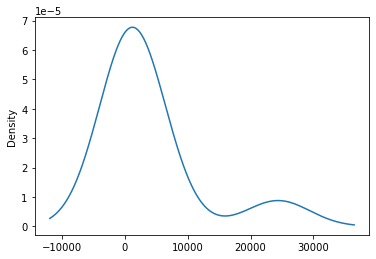

In [7]:
## INCOME Density Plot
income_amount_count.plot.density()

In [8]:
# Determine which values to replace if counts are less than ...?
replace_income_amt = list(income_amt_counts[income_amt_counts <900].index)

# Replace in dataframe
for app in replace_income_amt:
    application_df['INCOME_AMT'] = application_df['INCOME_AMT'].replace(app,"Other")
    
# Check to make sure binning was successful
application_df['INCOME_AMT'].value_counts()

0                24388
25000-99999       3747
100000-499999     3374
Other             1835
1M-5M              955
Name: INCOME_AMT, dtype: int64

In [9]:
# Bin APPLICATION TYPE
application_type_count = application_df['APPLICATION_TYPE'].value_counts()
application_type_count

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T29        2
T15        2
T17        1
Name: APPLICATION_TYPE, dtype: int64

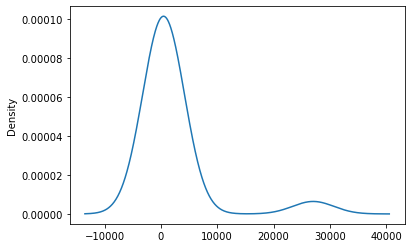

In [10]:
## APPLICATION TYPE Density Plot
application_type_count.plot.density();

In [12]:
# Determine which values to replace if counts are less than ..?
replace_app = list(application_type_count[application_type_count <1000].index)

# Replace in dataframe
for cls in replace_app:
    application_df['APPLICATION_TYPE'] = application_df['APPLICATION_TYPE'].replace(cls,"Other")
    
# Check to make sure binning was successful
application_df['APPLICATION_TYPE'].value_counts()

T3       27037
Other     2266
T4        1542
T6        1216
T5        1173
T19       1065
Name: APPLICATION_TYPE, dtype: int64

In [13]:
# Generate our categorical variable lists
application_cat = application_df.dtypes[application_df.dtypes =='object'].index.tolist()
application_cat

['APPLICATION_TYPE',
 'AFFILIATION',
 'CLASSIFICATION',
 'USE_CASE',
 'ORGANIZATION',
 'INCOME_AMT']

In [14]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df[application_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(application_cat)
encode_df.head()

,APPLICATION_TYPE_Other,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,AFFILIATION_CompanySponsored,AFFILIATION_Family/Parent,AFFILIATION_Independent,AFFILIATION_National,...,USE_CASE_ProductDev,ORGANIZATION_Association,ORGANIZATION_Co-operative,ORGANIZATION_Corporation,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_100000-499999,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_Other
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [15]:
# Merge one-hot encoded features and drop the originals
application_df = application_df.merge(encode_df,left_index=True,right_index=True).drop(application_cat,1)
application_df.head()

,EIN,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,AFFILIATION_CompanySponsored,...,USE_CASE_ProductDev,ORGANIZATION_Association,ORGANIZATION_Co-operative,ORGANIZATION_Corporation,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_100000-499999,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_Other
0,10520599,5000,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,10531628,108590,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,10547893,5000,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,10553066,6692,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,10556103,142590,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [16]:
# Split our preprocessed data into our features and target arrays
y = application_df['IS_SUCCESSFUL'].values
X = application_df.drop(['IS_SUCCESSFUL'],1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [17]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [18]:

# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train[0])
hidden_nodes_layer1 =  100
hidden_nodes_layer2 = 50
hidden_nodes_layer3 = 80

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))


# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="sigmoid"))


# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="sigmoid"))


# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               10000     
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 80)                4080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 81        
Total params: 19,211
Trainable params: 19,211
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Create a callback that saves the model's weights every 5 epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=1000)

In [20]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [21]:
# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=100)

Epoch 1/100
804/804 [==============================] - 2s 2ms/step - loss: 0.6053 - accuracy: 0.6824
Epoch 2/100
804/804 [==============================] - 1s 2ms/step - loss: 0.5513 - accuracy: 0.7344
Epoch 3/100
804/804 [==============================] - 1s 2ms/step - loss: 0.5502 - accuracy: 0.7341
Epoch 4/100
804/804 [==============================] - 1s 2ms/step - loss: 0.5522 - accuracy: 0.7299
Epoch 5/100
804/804 [==============================] - 1s 2ms/step - loss: 0.5484 - accuracy: 0.7348: 0s - loss: 0.5483 - accuracy: 0.
Epoch 6/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5503 - accuracy: 0.7304
Epoch 7/100
804/804 [==============================] - 1s 2ms/step - loss: 0.5458 - accuracy: 0.7329
Epoch 8/100
804/804 [==============================] - 1s 2ms/step - loss: 0.5429 - accuracy: 0.7325
Epoch 9/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5389 - accuracy: 0.7402
Epoch 10/100
804/804 [==============================] - 1

804/804 [==============================] - 1s 2ms/step - loss: 0.5056 - accuracy: 0.7546
Epoch 81/100
804/804 [==============================] - 1s 2ms/step - loss: 0.5048 - accuracy: 0.7549
Epoch 82/100
804/804 [==============================] - 1s 2ms/step - loss: 0.5029 - accuracy: 0.7559
Epoch 83/100
804/804 [==============================] - 1s 2ms/step - loss: 0.5002 - accuracy: 0.7596
Epoch 84/100
804/804 [==============================] - 1s 2ms/step - loss: 0.5057 - accuracy: 0.7566
Epoch 85/100
804/804 [==============================] - 1s 2ms/step - loss: 0.5055 - accuracy: 0.7536
Epoch 86/100
804/804 [==============================] - 1s 2ms/step - loss: 0.5035 - accuracy: 0.7547
Epoch 87/100
804/804 [==============================] - 1s 2ms/step - loss: 0.5022 - accuracy: 0.7564
Epoch 88/100
804/804 [==============================] - 1s 2ms/step - loss: 0.5032 - accuracy: 0.7549
Epoch 89/100
804/804 [==============================] - 1s 2ms/step - loss: 0.5010 - accuracy: 

In [22]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5605 - accuracy: 0.7315
Loss: 0.5604612827301025, Accuracy: 0.7315452098846436


In [23]:
nn.save("AlphabetSoupCharity_Optimization2.h5")